## Prepare Notebook

- [Modeling_with_JointDistribution](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Modeling_with_JointDistribution.ipynb)

- [Gaussian Process Regression in TensorFlow Probability](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb)

In [189]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
dtype = tf.float64
# Data Viz. 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [190]:
# Number of samples. 
n = 1000
# Generate "time" variable. 
data_df = pd.DataFrame(data={'t' : np.arange(n)})

In [191]:
# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    return amplitude * np.sin((2*np.pi)*t/period) 

np.random.seed(42)
sigma_n = 0.3

data_df = data_df \
    .assign(
        s1 = lambda x: seasonal(t=x['t'], amplitude=2, period=40), 
        epsilon = np.random.normal(loc=0, scale=sigma_n, size=n),
        y1 = lambda x: x['s1'] + x['epsilon']
    )

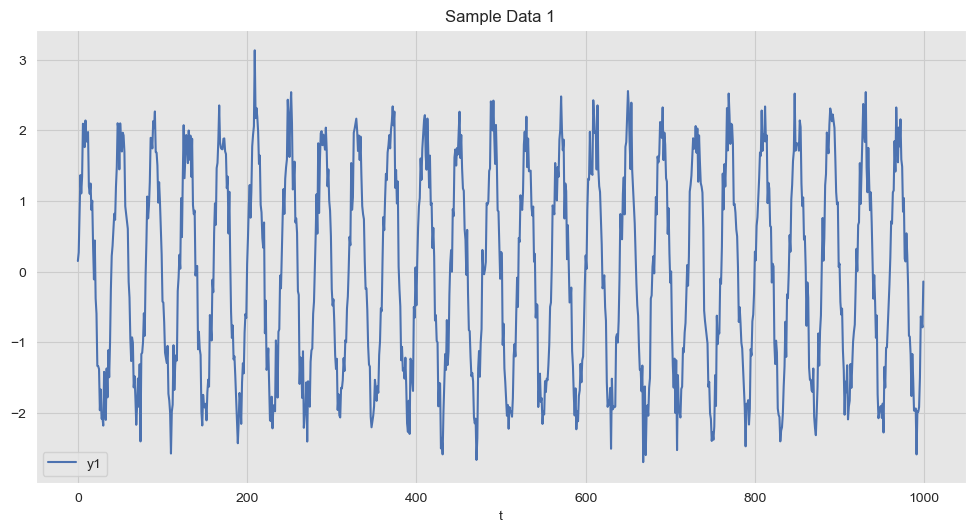

In [192]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label='y1', ax=ax) 
ax.set(title='Sample Data 1', xlabel='t', ylabel='')
ax.legend(loc='lower left');

In [193]:
y = tf.convert_to_tensor(value=data_df['y1'], dtype=dtype)
x = tf.convert_to_tensor(value=data_df['t'], dtype=dtype)

x = tf.reshape(x, [-1, 1])
y = tf.reshape(y, [-1, 1])

prop_train = 0.7
n_train = round(prop_train*n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

In [194]:
def build_gp_model(amplitude, length_scale, period, observation_noise_variance): 
    # Set Gaussian Process kernel. 
    kernel = tfk.ExpSinSquared(
        amplitude=amplitude,
        length_scale=length_scale, 
        period=period
    )
    # Return Gaussian Process distribution. 
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=x_train,
        mean_fn=None,
        observation_noise_variance=observation_noise_variance
    )


gp_joint_model = tfd.JointDistributionNamed(dict(
    amplitude=tfd.LogNormal(loc=tf.cast(1.0, dtype), scale=tf.cast(1.0, dtype)),
    length_scale=tfd.LogNormal(loc=tf.cast(0.0, dtype), scale=tf.cast(1.0, dtype)),
    period=tfd.LogNormal(loc=tf.cast(3.0, dtype), scale=tf.cast(1.0, dtype)),
    observation_noise_variance=tfd.LogNormal(loc=tf.cast(0.0, dtype), scale=tf.cast(1.0, dtype)),
    observations=build_gp_model
))

In [198]:
tf.random.set_seed(42)

gp_prior_samples = gp_joint_model.sample(20)

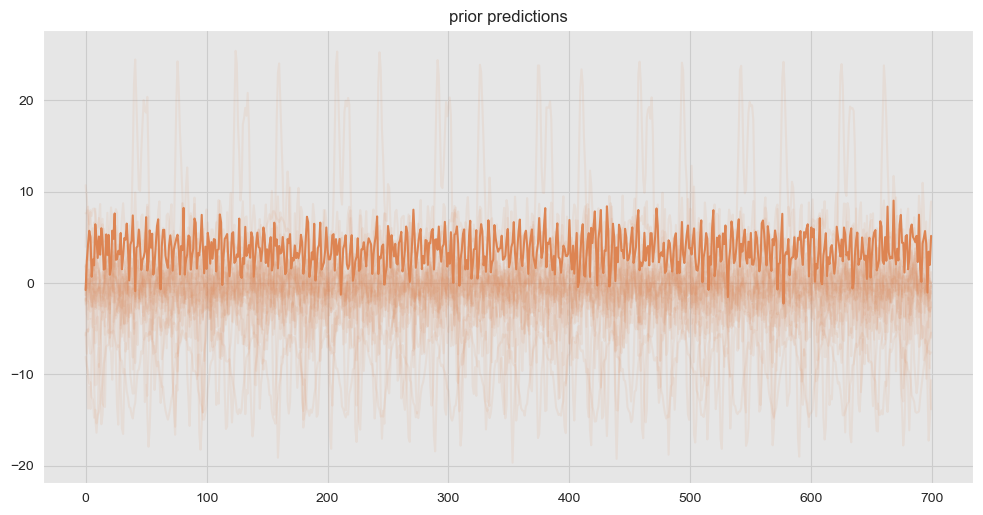

In [201]:
fig, ax = plt.subplots()

for i in range(1, 20):     
    sns.lineplot(
        x=x_train[..., 0].numpy(), 
        y=gp_prior_samples['observations'][i, ].numpy(), 
        color=sns_c[1],
        alpha=0.1,
        ax=ax
    )

sns.lineplot(
    x=x_train[..., 0].numpy(), 
    y=gp_prior_samples['observations'][0, ].numpy(), 
    color=sns_c[1],
    ax=ax
)

ax.set(title='prior predictions');